In [1]:
# Connexion au répertoire
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Imports

In [2]:
# Libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm
import itertools
import PIL
import cv2

# Data Analysis
import matplotlib.pyplot as plt

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tensorflow import keras

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

# Config

In [3]:
# Chemin d'accès ### A MODIFIER EN LOCAL !!
path = "/content/gdrive/MyDrive/Projet Radio_DS/data/"
ID_DIR = 6

# Accès aux sous-dossiers
dirsi = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsim = ["Normal/masked_images/","COVID/masked_images/","Lung_Opacity/masked_images/","Viral Pneumonia/masked_images/"]


# Images à traiter (brutes ou masquées) et taille échantillon
dirs = dirsim


# Classes de catégorisation
classes = ("Non Covid","Covid")
nbClasses = len(classes)

# Paramètres
SIZE = (240,240)
RATIO_VAL = 0.2
BATCH_SIZE = 32 # Batch pour générateur d'images
MODEL_BATCH_SIZE = 32 # Batch pour entrainement modèle
NB_EPOCHS = 30

# Taille échantillon et équilibrage des images pour classification binaire
ECH_SIZE = 1000 #(max 2000 sur images masquées par seul un échantillon dispo)

nb_covid_images = ECH_SIZE // nbClasses #La moitié de l'échantillon est Covid
nb_other_class_images = np.round((ECH_SIZE - nb_covid_images) /3).astype(int) # A des fins d'équilibrage, l'autre moitié est divisée par le nombre de catégories restantes

class_sizes = [nb_other_class_images, nb_covid_images, nb_other_class_images, nb_other_class_images] #Taille total image par catégorie
test_class_sizes = [int(RATIO_VAL *nb_other_class_images), int(RATIO_VAL * nb_covid_images), int(RATIO_VAL * nb_other_class_images), int(RATIO_VAL * nb_other_class_images)] #Taille images de test par catégorie



# Création des dataframes

In [4]:
### Création des listes d'emplacement pour chaque catégorie

liste_paths = [] #Sert à créer le dataframe
liste_test = [] # Sert à conserver toujours les mêmes mages de test (pour tous les modèles)

for class_dir, class_size, test_class_size in zip(dirs, class_sizes, test_class_sizes) :
  class_images_names = [fn for fn in os.listdir(path + class_dir) if fn.endswith('.png')]
  for filename in class_images_names[0: class_size] :
    liste_paths.append(path + class_dir + filename)

  # Récupération d'un échantillon de test
  for i in range(test_class_size):
    liste_test.append(liste_paths[-test_class_size:][i])
  liste_paths = liste_paths[:-test_class_size]

# Récupération de la catégorie de chaque image
liste_paths = list(map(lambda x : [x, x.split('/')[ID_DIR]], liste_paths))
liste_test = list(map(lambda x : [x, x.split('/')[ID_DIR]], liste_test))

In [5]:
# Création d'un DataFrame Entrainement et de validation
df = pd.DataFrame(liste_paths, columns = ['filepath', 'nameLabel'])

df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df["is_covid"] = df["label"].replace((2,3), (0,0))

df['label'] = df['label'].astype(str)
df['is_covid'] = df['is_covid'].astype(str)


# Mélange du dataframe
df =  df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

# Nettoyage variables inutiles
del liste_paths

print(df["nameLabel"].value_counts())
print(df["is_covid"].value_counts())
df.head()

COVID              400
Lung_Opacity       134
Viral Pneumonia    134
Normal             134
Name: nameLabel, dtype: int64
0    402
1    400
Name: is_covid, dtype: int64


,filepath,nameLabel,label,is_covid
0,/content/gdrive/MyDrive/Projet Radio_DS/data/C...,COVID,1,1
1,/content/gdrive/MyDrive/Projet Radio_DS/data/C...,COVID,1,1
2,/content/gdrive/MyDrive/Projet Radio_DS/data/C...,COVID,1,1
3,/content/gdrive/MyDrive/Projet Radio_DS/data/C...,COVID,1,1
4,/content/gdrive/MyDrive/Projet Radio_DS/data/L...,Lung_Opacity,2,0


In [6]:
# Création du DataFrame de test
df_test = pd.DataFrame(liste_test, columns = ['filepath', 'nameLabel'])

df_test['label'] = df_test['nameLabel'].replace(df_test.nameLabel.unique(), [*range(len(df_test.nameLabel.unique()))])
df_test["is_covid"] = df_test["label"].replace((2,3), (0,0))

df_test['label'] = df_test['label'].astype(str)
df_test['is_covid'] = df_test['is_covid'].astype(str)

# Nettoyage variables inutiles
del liste_test

print(df_test["nameLabel"].value_counts())
print(df_test["is_covid"].value_counts())
df_test.head()

COVID              100
Normal              33
Lung_Opacity        33
Viral Pneumonia     33
Name: nameLabel, dtype: int64
1    100
0     99
Name: is_covid, dtype: int64


,filepath,nameLabel,label,is_covid
0,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0,0
1,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0,0
2,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0,0
3,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0,0
4,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0,0


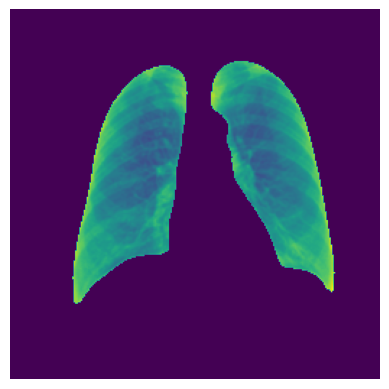

In [7]:
### Exemple d'images

filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

# Itérateurs d'images

In [8]:
# Séparation dataframe en ensemble entrainement et validation
train, valid = train_test_split(df, test_size=RATIO_VAL, shuffle = False)


# Création des itérateurs qui chargeront des lots d'images
train_data_generator = ImageDataGenerator( )
valid_data_generator = ImageDataGenerator( )
test_data_generator = ImageDataGenerator( )

# Initialisation du image generator de train
print(f"Number of rows in train set: {len(train)}")
train_generator = train_data_generator.flow_from_dataframe(dataframe = train,
                                                           x_col="filepath",
                                                           y_col="is_covid",
                                                           class_mode = "binary",
                                                           target_size = SIZE, #Resize
                                                           batch_size = BATCH_SIZE,
                                                           #color_mode = "grayscale"
                                                           )

# Initialisation du image generator de validation
print(f"Number of rows in valid set: {len(valid)}")
valid_generator = valid_data_generator.flow_from_dataframe(dataframe = valid,
                                                         x_col="filepath",
                                                         y_col="is_covid",
                                                         class_mode = "binary",
                                                         target_size = SIZE, #Resize
                                                         batch_size = BATCH_SIZE,
                                                         #color_mode = "grayscale", # Pas de grayscale, en rgb
                                                         shuffle = False)


# Initialisation du image generator de test
print(f"Number of rows in test set: {len(df_test)}")
test_generator = test_data_generator.flow_from_dataframe(dataframe = df_test, #Utilisation du dataframe de test
                                                         x_col="filepath",
                                                         y_col="is_covid",
                                                         class_mode = "binary",
                                                         target_size = SIZE, #Resize
                                                         batch_size = BATCH_SIZE,
                                                         #color_mode = "grayscale", # Pas de grayscale, en rgb
                                                         shuffle = False)

Number of rows in train set: 641
Found 641 validated image filenames belonging to 2 classes.
Number of rows in valid set: 161
Found 161 validated image filenames belonging to 2 classes.
Number of rows in test set: 199
Found 199 validated image filenames belonging to 2 classes.


# Création du modèle

In [9]:
#Définition entrée du modèle
input_model = Input(shape = (240,240,3))

#Chargement et freeze modèle de base Eficient Net
base_model = EfficientNetB1(weights = 'imagenet', include_top=False, input_shape=(240,240,3))
for layer in base_model.layers :
    layer.trainable = False

# Création des différentes couches
global_average = GlobalAveragePooling2D()
dense1 = Dense(units = 1024, activation = "relu")
dropout1 = Dropout(rate=0.2)
dense2 = Dense(units = 512, activation = "relu")
dropout2 = Dropout(rate=0.2)
dense3 = Dense(units = 1, activation = "sigmoid")

#Application des opérations
x = base_model.output
x = global_average(x)
x = dense1(x)
x = dropout1(x)
x = dense2(x)
x = dropout2(x)
output_model = dense3(x)

#Création du modèle
model = Model(inputs = base_model.input, outputs = output_model)

# Compilation
model.compile(loss = "BinaryCrossentropy", optimizer = "Adam", metrics = ["accuracy"])


model.summary()

27018416/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)     

# Callbacks

In [10]:
#Création de callbacks

#checkpoint
checkpoint = ModelCheckpoint( path + 'model.h5',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'auto',
                             verbose = 1)

#early stopping'
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 5,
                          mode = 'auto',
                          verbose = 1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode = 'auto',
                              verbose = 1)

# Entrainement du modèle

In [11]:
# Récupération des tailles d'échantillon
train_size = train_generator.samples
valid_size = valid_generator.samples

# Entrainement du modèle avec callbacks
history = model.fit(train_generator,
                    epochs = NB_EPOCHS,
                    steps_per_epoch = train_size // MODEL_BATCH_SIZE,
                    validation_data = valid_generator,
                    validation_steps = valid_size // MODEL_BATCH_SIZE,
                    verbose = 1,
                    callbacks = [earlystop, reduce_lr])

Epoch 1/30
20/20 [==============================] - 146s 6s/step - loss: 0.6890 - accuracy: 0.6305 - val_loss: 0.5469 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 3s 137ms/step - loss: 0.5007 - accuracy: 0.7274 - val_loss: 0.4823 - val_accuracy: 0.7312 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 4s 188ms/step - loss: 0.4835 - accuracy: 0.7438 - val_loss: 0.4742 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 3s 143ms/step - loss: 0.4340 - accuracy: 0.7882 - val_loss: 0.4669 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.7931
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
20/20 [==============================] - 3s 139ms/step - loss: 0.4206 - accuracy: 0.7931 - val_loss: 0.4905 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 3s 141ms/step -

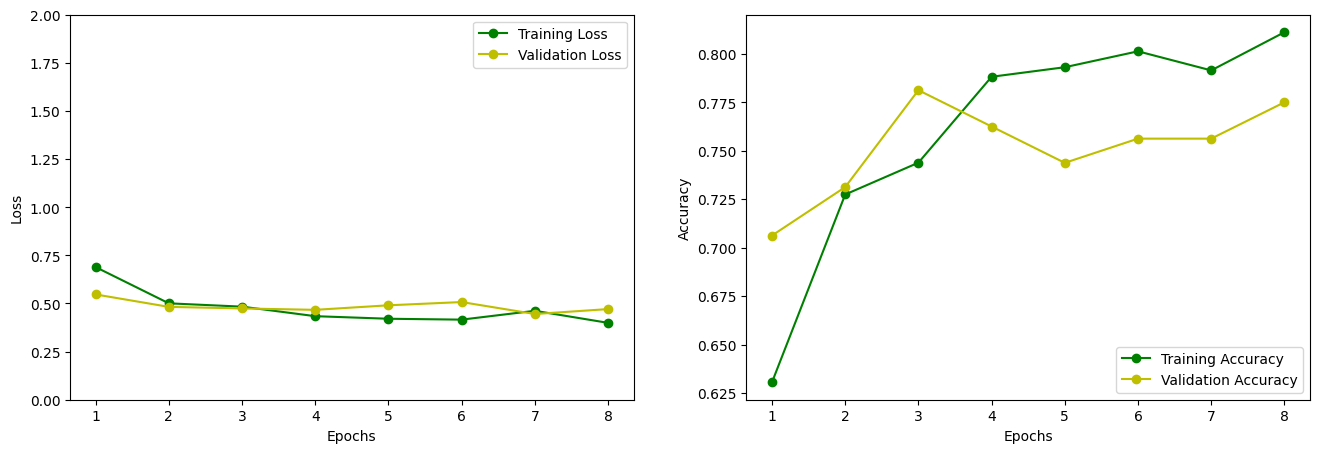

In [12]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Courbe de perte
plt.subplot(121)
plt.plot(epochs, train_loss, 'g-o', label = 'Training Loss')
plt.plot(epochs, val_loss, 'y-o',  label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

# Courbe d'accuracy
plt.subplot(122)
plt.plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

# Evaluation des performances

In [13]:
#Acccuracy et perte pour ensemble entrainement, validation et test
print('TRAIN loss & accuracy :', model.evaluate(train_generator))
print('\n')
print('VALID loss & accuracy :', model.evaluate(valid_generator))
print('\n')
print('TEST loss & accuracy :', model.evaluate(test_generator))

21/21 [==============================] - 3s 142ms/step - loss: 0.3662 - accuracy: 0.8284
TRAIN loss & accuracy : [0.3662230670452118, 0.8283931612968445]


6/6 [==============================] - 1s 88ms/step - loss: 0.4722 - accuracy: 0.7702
VALID loss & accuracy : [0.4722225069999695, 0.7701863646507263]


7/7 [==============================] - 25s 4s/step - loss: 0.3816 - accuracy: 0.7789
TEST loss & accuracy : [0.38163384795188904, 0.7788944840431213]


In [14]:
# Calcul des prédictions (test)

y_pred = np.round(model.predict(test_generator)) # On arrondi à l'entier pour retrouver la prédiction

7/7 [==============================] - 3s 98ms/step


In [15]:
# Fonction d'affichage de matrice de confusion
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


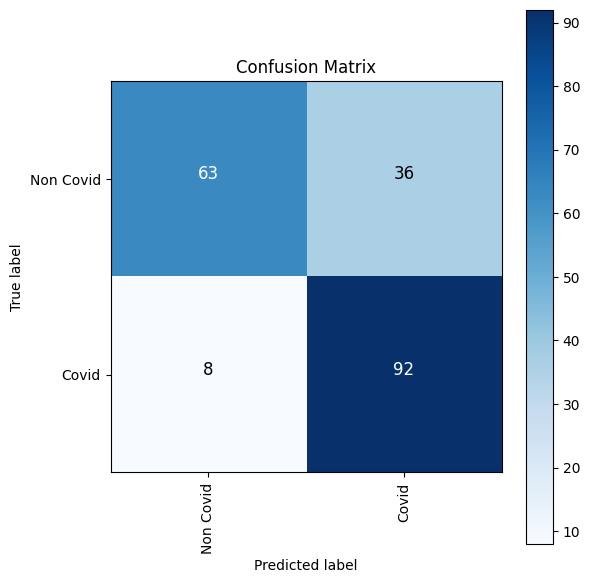

In [16]:
# Calcul et affichage matrice de confusion
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes, normalize = False)

In [17]:
# Rapport de classification

print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.64      0.74        99
           1       0.72      0.92      0.81       100

    accuracy                           0.78       199
   macro avg       0.80      0.78      0.77       199
weighted avg       0.80      0.78      0.77       199



# Prédictions sur des images test

In [18]:
# Stockage de l'ensemble de test en array
X_test = []
for filepath in tqdm(df_test['filepath']) :
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels = 1)
    im = tf.image.resize (im, SIZE)
    X_test.append([im])

X_test = tf.concat(X_test, axis = 0)

100%|██████████| 199/199 [00:00<00:00, 315.58it/s]


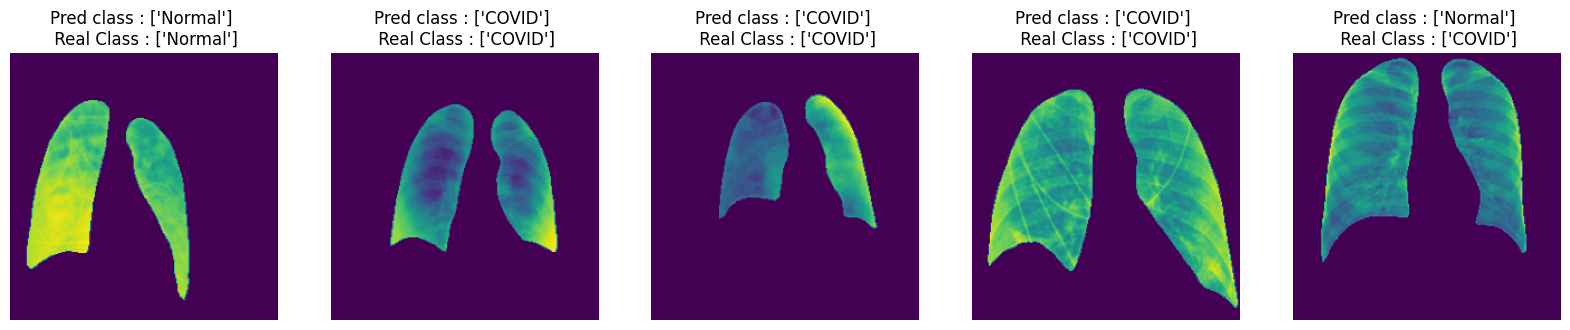

In [19]:
# Choix d'images au hasard et affichage

y_test = pd.DataFrame(test_generator.classes).astype(int)

indices_random = tf.random.uniform([5], 0, len(df_test['filepath']), dtype = tf.int32)

plt.figure(figsize = (20,10))

for i, idx in enumerate(indices_random) :
    plt.subplot(1,5,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.axis('off')
    plt.title('Pred class : {} \n Real Class : {}'.format(df_test.nameLabel.unique()[y_pred[idx].astype(int)], df_test.nameLabel.unique()[y_test.values[idx]]))

# Sauvegarde et chargement modèles

In [20]:
#Enregistrement modèle
model.save_weights(path + "model_efnet1_bin_1000imk_30ep_imnt.h5")

In [21]:
#Chargement modèle
model.load_weights(path + "model_efnet1_bin_1000imk_30ep_imnt.h5")